## CNN autoencoder
### convLSTM autoencoder?

# test with kldivergence instead of mse
# make time steps overlapping
# try id as binary instead of dec

## Prepare data

In [1]:
from matplotlib import pyplot
import keras
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import GRU
from keras.layers import Conv3D
from keras.layers import UpSampling3D
from keras.layers import MaxPool3D
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import GlobalAveragePooling2D
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
from numpy import array

In [2]:
from data_processing import process
filename = 'gear_dataset.csv'
rows = 5000  # no attack data in the first 1000 rows
data_with_attack, AttackIDs, labeled_data = process(filename,rows,no_attack_packets=False) 
print(f'including attack data: {data_with_attack.shape}')

data , IDs, _ = process(filename,rows,no_attack_packets=True)
print(f'normal data: {data.shape}')

n_rows = data.shape[0] 
n_features = data.shape[1]



number of attack packets in data set = 922
including attack data: (4959, 64)
dropped 922 attack packets
normal data: (4037, 64)


In [3]:
n_timesteps = 40

labeled_data = labeled_data.reset_index(drop=True)

from prepare_data_cube import make_cubes

type = 'timeDist_cnn'
#type = 'cnn_lstm'
x_test,x_train,xA,lastA = make_cubes(IDs,AttackIDs,data,data_with_attack,n_timesteps,type,labeled_data)

attack = labeled_data[labeled_data['Attack'] == 'T'].copy()
attack_ind = attack.index
attack_ind = attack_ind[attack_ind<=lastA]
attack_samples = np.floor(attack_ind/n_timesteps)
attack_samples = np.unique(attack_samples) # all samples that contain attack packets
attack_samples = attack_samples.astype(int)

id.shape = (4037, 16)
ID_matrix.shape = (64, 1, 4037, 16)
ID_matrix.shape = (64, 4037, 16)
data shape: (4037, 64)


ValueError: could not broadcast input array from shape (16,4037,64) into shape (16,64,4037)

In [1]:
x_test[0,0,:,0,0]

NameError: name 'x_test' is not defined

## Build network

best value so far on lstm tuning: 
uniformMin = -0.89
uniformMax = 0.07
lstmUnits = 491
denseUnits = 2060
dropout = 0.3
learning_rate = 0.001
tuner/epochs = 2
tuner/initial_e... = 0
tuner/bracket = 4
tuner/round = 0


In [7]:
# cnn
# channels?? 2d or 3d? think 3d because there are correlations between the two cannels
# relu much better than sigmoid
n_features = 64
depth = 2

input = Input(shape=(n_timesteps,n_features,depth, 1))

x = Conv3D(filters = 60, kernel_size = (2, 2, 1), activation='relu', padding='same')(input) 
x = Conv3D(filters = 60, kernel_size = (2, 2, 1), activation='relu', padding='same')(x)
#x = MaxPool3D((2,2,2),padding='valid')(x)

x = Conv3D(filters = 60, kernel_size = (2, 2, 1), activation='relu', padding='same')(x)
#x = UpSampling3D(size=(2, 2, 2))(x)

x = Conv3D(filters = 1, kernel_size = (2, 2, 1), activation='relu', padding='same')(x)

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='mse')
CNN.summary()


Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 64, 2, 1)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 40, 64, 2, 60)     300       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 40, 64, 2, 60)     14460     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 40, 64, 2, 60)     14460     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 40, 64, 2, 1)      241       
Total params: 29,461
Trainable params: 29,461
Non-trainable params: 0
_________________________________________________________________


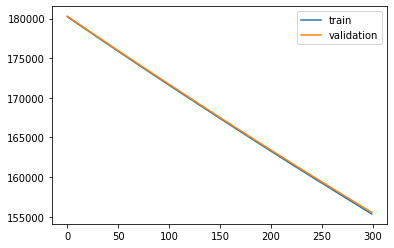

training time = 111.44742321968079 seconds


In [17]:

import time

model = CNN
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

s = time.time()

history = model.fit(x_train,x_train, validation_data=(x_test, x_test), epochs=300, verbose=0, shuffle=False, callbacks = [es])

e = time.time()

# plot history
pyplot.plot(history.history['loss'], label = 'train')
pyplot.plot(history.history['val_loss'], label = 'validation')

pyplot.legend()
pyplot.show()
print(f'training time = {e-s} seconds')



input = Input(shape=(n_timesteps,n_features,n_channels, 1))

    *l1 = Conv3D(filters = 60, kernel_size = (2, 2, 2), activation='relu', padding='same')(input) * these are changed, kernel size and filters
    *l2 = Conv3D(filters = 60, kernel_size = (2, 2, 2), activation='relu', padding='same')(l1)
#l3 = MaxPool3D((2,2,2),padding='valid')(l2)
    *l4 = Conv3D(filters = 60, kernel_size = (2, 2, 2), activation='relu', padding='same')(l2)
    l5 = Conv3D(filters = 1, kernel_size = (2, 2, 2), activation='relu', padding='same')(l4) only change kernel size here
all using nrows = 1000, patience = 10, epochs = 300 

kernel in third dim must be smaller than input to be able to establish correlations in this dim.

loss: 120.9649 - val_loss: 235.5185 for kernel = 3,3,1, 16 filters    
loss: 76.3744 - val_loss: 161.5475 for kernel = 3,3,3, 16 filters  
loss: 6.2998 - val_loss: 7.3455 for kernel = 2, 2, 2, 60 filters  
loss: 24 - val_loss: 21.1457 for kernel = 2, 2, 2, 80 filters  
loss: 3.4384 - val_loss: 4.4540 for kernel = 2, 2, 1, 60 filters
loss: 8.4616 - val_loss: 604.7426 for kernel = 10, 2, 1, 60 filters (training time = 2193.382426261902 seconds) 

using nrows = 10000:
early stopping: Epoch 218/300: loss: 0.7777 - val_loss: 0.7862 (best around epoch 208:loss: 0.4987 - val_loss: 0.4804) for kernel = 2, 2, 1, 60 filters 40 timesteps!

In [6]:
xA.shape

(247, 64, 2, 20)

(30, 40, 64, 2, 60)
normal: 612761.9883480127
(123, 40, 64, 2, 60)
normal and attack: 587839.1576082293
(71, 40, 64, 2, 60)
only attack: 686848.1302125319
(30,)
(123,)
(71,)


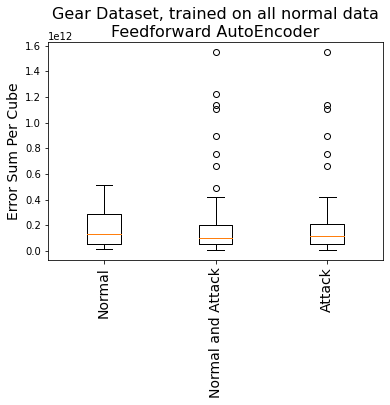

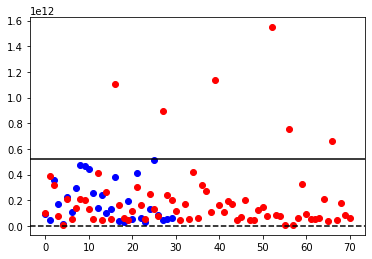

In [5]:
#model =  keras.models.load_model('CNN_LSTM_monday')
# test with attack included
CNN = model
from matplotlib import pyplot as plt  

if type == 'timeDist_cnn':
    attack_cubes = xA[attack_samples,:,:,:,:]

if type == 'cnn_lstm':
    attack_cubes = xA[attack_samples,:,:,:]

yHat_normal = CNN.predict(x_test) # only normal packets
normal_errors = x_test-yHat_normal
print(yHat_normal.shape)
normal_errors = normal_errors.flatten()
normal_errors = np.abs(normal_errors)
normal_errors = np.mean(normal_errors)
print(f'normal: {normal_errors}')


yHat_attack = CNN.predict(xA) # normal and attack packets
attack_errors = xA-yHat_attack
print(yHat_attack.shape)
attack_errors = attack_errors.flatten()
attack_errors = np.abs(attack_errors)
attack_errors = np.mean(attack_errors)
print(f'normal and attack: {attack_errors}')

yHat_true_attack = CNN.predict(attack_cubes) # only attack packets
true_attack_errors = attack_cubes-yHat_true_attack
print(yHat_true_attack.shape)
true_attack_errors = true_attack_errors.flatten()
true_attack_errors = np.abs(true_attack_errors)
true_attack_errors = np.mean(true_attack_errors)
print(f'only attack: {true_attack_errors}')


# get average for each sample cube 
normal_errors = x_test-yHat_normal

if type == 'timeDist_cnn':
    normal_errors = normal_errors.reshape(normal_errors.shape[0],normal_errors.shape[1]*normal_errors.shape[2]*normal_errors.shape[3]*normal_errors.shape[4])

if type == 'cnn_lstm':
    normal_errors = normal_errors.reshape(normal_errors.shape[0],normal_errors.shape[1]*normal_errors.shape[2]*normal_errors.shape[3])

normal_errors = np.abs(normal_errors)
normal_errors = np.sum(normal_errors,axis=1)
#normal_errors = normal_errors/normal_errors.shape[0]
print(normal_errors.shape)

attack_errors = xA-yHat_attack
if type == 'timeDist_cnn':
    attack_errors = attack_errors.reshape(attack_errors.shape[0],attack_errors.shape[1]*attack_errors.shape[2]*attack_errors.shape[3]*attack_errors.shape[4])

if type == 'cnn_lstm':
    attack_errors = attack_errors.reshape(attack_errors.shape[0],attack_errors.shape[1]*attack_errors.shape[2]*attack_errors.shape[3])

attack_errors = np.abs(attack_errors)
attack_errors = np.sum(attack_errors,axis=1)
#attack_errors = attack_errors/attack_errors.shape[0]
print(attack_errors.shape)

true_attack_errors = attack_cubes-yHat_true_attack
if type == 'timeDist_cnn':
    true_attack_errors = true_attack_errors.reshape(true_attack_errors.shape[0],true_attack_errors.shape[1]*true_attack_errors.shape[2]*true_attack_errors.shape[3] *true_attack_errors.shape[4])

if type == 'cnn_lstm':
    true_attack_errors = true_attack_errors.reshape(true_attack_errors.shape[0],true_attack_errors.shape[1]*true_attack_errors.shape[2]*true_attack_errors.shape[3])

true_attack_errors = np.abs(true_attack_errors)
true_attack_errors = np.sum(true_attack_errors,axis=1)
#attack_errors = attack_errors/attack_errors.shape[0]
print(true_attack_errors.shape)

plt.figure()
plt.boxplot([normal_errors, attack_errors,true_attack_errors]) 
plt.xticks([1,2,3], ['Normal','Normal and Attack','Attack'], rotation='vertical', fontsize=14)
plt.ylabel('Error Sum Per Cube', fontsize=14)
plt.title('Gear Dataset, trained on all normal data\nFeedforward AutoEncoder', fontsize=16)

maxNormal = np.max(normal_errors) + 0.01*np.max(normal_errors)
minAttack = np.min(true_attack_errors) - 0.01*np.max(normal_errors)

plt.figure()
#plt.scatter(np.arange(len(attack_errors)),attack_errors,c='y')
plt.scatter(np.arange(len(normal_errors)), normal_errors,c='b')
plt.scatter(np.arange(len(true_attack_errors)), true_attack_errors,c='r')
plt.axhline(y=maxNormal, color='k', linestyle='-')
plt.axhline(y=minAttack, color='k', linestyle='--')



# Why are errors shaped like waves?
should keep attack labels to find out if correct ones are found

In [7]:
#cnn
n_features = 64
depth = 2
n_timesteps = 24
input = Input(shape=(n_timesteps,n_features,depth, 1))

x = Conv3D(filters = 60, kernel_size = (2, 2, 1), strides=(2, 2, 1), activation='relu', padding='same')(input) 
x = MaxPool3D((4,4,2),padding='same')(x)

x = Conv3D(filters = 30, kernel_size = (2, 2, 1), strides=(2, 2, 1), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,1),padding='same')(x)

x = Conv3D(filters = 10, kernel_size = (2, 2, 1), strides=(2, 2, 1), activation='relu', padding='same')(x)
x = UpSampling3D(size=(2,2,2))(x)

x = Conv3D(filters = 30, kernel_size = (2, 2, 1), strides=(2, 2, 1), activation='relu', padding='same')(x)
x = UpSampling3D(size=(2,2,1))(x)

x = Conv3D(filters = 60, kernel_size = (2, 2, 1), strides=(2, 2, 1), activation='relu', padding='same')(x)
x = UpSampling3D(size=(3,4,1))(x)

x = Conv3D(filters = 1, kernel_size = (2, 2, 1), strides=(2, 2, 1), activation='relu', padding='same')(x)

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='mse')
CNN.summary()


Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 64, 2, 1)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 12, 32, 2, 60)     300       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 3, 8, 1, 60)       0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 8, 1, 30)       7230      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 4, 1, 30)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 4, 1, 10)       1210      
_________________________________________________________________
up_sampling3d (UpSampling3D) (None, 4, 8, 2, 10)       0       

In [5]:
# cnn_lstm
# Combine 2d CNN and LSTM
# could do 2d CNN and have each timestep as one channel! trained for 1500 but needs more
input = Input(shape=(n_features,2,n_timesteps))
outputs = []

x = Conv2D(filters = 60, kernel_size = (4, 1), activation='relu', padding='same')(input) 
x = MaxPool2D((2,1),padding='valid')(x)

x = Conv2D(filters = n_timesteps, kernel_size = (1, 1), activation='relu', padding='same')(x)
x = MaxPool2D((2, 1))(x)

x = Conv2D(filters = n_timesteps, kernel_size = (2, 1), activation='relu', padding='same')(x)
x = MaxPool2D((2, 2))(x)

# x = Conv2D(filters = n_timesteps, kernel_size = (2, 1), activation='relu', padding='same')(x)
# x = MaxPool2D((2, 1))(x)

# x = Conv2D(filters = n_timesteps, kernel_size = (2, 1), activation='relu', padding='same')(x)
# x = MaxPool2D((2, 1))(x)

# x = Conv2D(filters = n_timesteps, kernel_size = (2, 1), activation='relu', padding='same')(x)
# x = MaxPool2D((2, 2))(x)

x = Reshape((n_timesteps,8, ))(x)
#outputs.append(x)
# LSTM [samples,timesteps,features]
x = LSTM(64,return_sequences = True)(x)
x = LSTM(128, return_sequences = True)(x)

x = Reshape((64,2,n_timesteps,))(x)
x = Conv2D(filters = n_timesteps, kernel_size = (2, 1), activation='relu', padding='same')(x)
# conv





CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='mse')
CNN.summary()


Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 2, 6)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 2, 60)         1500      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 2, 60)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 2, 6)          366       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 2, 6)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 2, 6)          78        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 1, 6)           0       

In [6]:
CNN.save('CNN_LSTM_trained_on_50000_nonattack')

NameError: name 'CNN' is not defined

In [11]:
len(bin(int('043f', 16))[2:])

11

In [12]:
 format(int('043f', base=16), "032b")

'00000000000000000000010000111111'

In [9]:
# timeDist_cnn

model = Sequential()
n_features = 64
model.add(
    TimeDistributed(
        Conv2D(60, (2,1), activation='relu',padding='same'), 
        input_shape=(n_timesteps, n_features, 2, 1) # 5 images...
    )
)
model.add(
    TimeDistributed(
        Conv2D(30, (2,1), activation='relu',padding='same')
    )
)

model.add(
    TimeDistributed(
        MaxPool2D((2, 2),padding='same')
    )
)

model.add(
    Reshape((n_timesteps,-1)))

model.add(
   LSTM(128, activation='relu', return_sequences=True)
)

model.add(
   LSTM(10, activation='relu', return_sequences=True)
)

model.add(
   LSTM(128, activation='relu', return_sequences=True)
)

model.add(
    TimeDistributed(
        Dense(960)
    )
)

model.add(
    Reshape((n_timesteps,32,1,30)))

model.add(
    TimeDistributed(
        UpSampling2D((2,2))
    )
)

model.add(
    TimeDistributed(
        Conv2D(60, (1,1), activation='relu',padding='same')
    )
)

model.compile('adam', loss='KLDivergence')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 6, 64, 2, 60)      180       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 6, 64, 2, 30)      3630      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 6, 32, 1, 30)      0         
_________________________________________________________________
reshape (Reshape)            (None, 6, 960)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 128)            557568    
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 10)             5560      
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 128)            7